In [1]:
# encoding: utf-8
import os
import numpy as np
import numpy
import pandas as pd
import random
import math
from numpy import array
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True

sess = tf.Session(config=config)

from tensorflow.nn.rnn_cell import LSTMStateTuple

from scipy.io import loadmat, savemat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base = ['vnf label', 'vnf min cpu', 'vnf min mem', 'vnf min sto', 'vnf vm cpu',
       'vnf vm mem', 'vnf vm sto', 'vnf pm id', 'vnf cpu usage',
       'vnf mem usage', 'vnf sto usage', 'vnf before', 'vnf after',
       'vnf label.1', 'vnf min cpu.1', 'vnf min mem.1', 'vnf min sto.1',
       'vnf vm cpu.1', 'vnf vm mem.1', 'vnf vm sto.1', 'vnf pm id.1',
       'vnf cpu usage.1', 'vnf mem usage.1', 'vnf sto usage.1', 'vnf before.1',
       'vnf after.1', 'sla', 'fg id', 'flow traffic', 'flow latency',
       'flow bnd usage', 'flow packet loss', 'min cpu affinity',
       'min mem affinity', 'min sto affinity', 'conflicts affinity',
       'real_affinity', 'static_affinity', 'predicted_affinity',
       'prediction_time', 'TF', 'MTT', 'MTT_upper', 'MTT_lower', 'MTTF_R',
       'MTTF_EM', 'MTTF_C', 'MTTF_TDDB', 'MTTF_SM', 'MTTFF_TC', 'A', 'AEM',
       'AC', 'ATDDB', 'ASM', 'ATC', 'TAA', 'QRED', 'QR', 'PUE', 'DCie', 'cost',
       'TIMESTAMP', 'EXTERNAL_TEMP', 'ROOM_TEMP', 'MTTF_IC', 'A_TC', 'Q_DIT',
       'TPF', 'AIRFLOW', 'TAAF', 'DeltaT_de', 'QD']
       
       
#Select your global variable among one of above, and set iet as base below


base = 'vnf cpu usage'


In [3]:
fgs = pd.read_csv('../fgs.csv')

In [4]:
fgs.head()

,,,,4963594775,1,2
proxy.9.5698,traffic counter.7.5664,0.971442,82.243099,1.794354,9.341767,100.0
5402488769,5,1.000000,NaN,NaN,NaN,NaN
traffic counter.7.7413,proxy.9.11244,4.060322,119.086081,16.548350,8.474562,150.0
proxy.9.11244,proxy.9.2362,0.268318,23.865256,11.573841,9.248256,150.0
proxy.9.2362,traffic counter.7.9524,2.961259,80.083566,18.280812,4.783467,150.0


In [5]:
vns = pd.read_csv('../vnfs.csv', header=None)

In [6]:
vnf_id = np.array(vns[vns.columns[0]])
vnf_type = np.array(vns[vns.columns[1]])
vnf_scheduling = np.array(vns[vns.columns[2]])
vnf_pm = np.array(vns[vns.columns[3]])
vnf_fg = np.array(vns[vns.columns[4]])
flavor_data = np.array(vns[vns.columns[5:8]])
vm_data = np.array(vns[vns.columns[8:11]])
usage_data = np.array(vns[vns.columns[11:15]])

In [7]:
vm_data.shape

(12322, 3)

In [8]:
output = pd.read_csv('../new_results_out.csv', sep =';')#header=None)
output.drop('Unnamed: 0',axis = 1, inplace=True)

In [9]:
output.head()

,vnf label,vnf min cpu,vnf min mem,vnf min sto,vnf vm cpu,vnf vm mem,vnf vm sto,vnf pm id,vnf cpu usage,vnf mem usage,...,EXTERNAL_TEMP,ROOM_TEMP,MTTF_IC,A_TC,Q_DIT,TPF,AIRFLOW,TAAF,DeltaT_de,QD
0,dpi.2.136144,0.035914,0.226393,0.001757,0.06250,0.12720,0.001930,257345416,71.88000,1.75780,...,15,23,2435.249666,0.996726,1.839678,14.999377,0.131858,0.872117,6.132259,6.132259
1,traffic counter.7.40368,0.063818,0.017674,0.000223,0.06189,0.03821,0.000386,3488796635,3.51600,6.34800,...,15,24,49.077683,0.859840,1.801941,14.999402,0.142946,0.768427,6.006469,6.006469
2,proxy.9.13456,0.018672,0.020912,0.000006,0.01250,0.01590,0.000404,4820294844,0.18044,0.13352,...,55,25,82.372536,0.911478,1.800100,54.999420,0.152569,0.757640,6.000332,6.000332
3,firewall.3.36933,0.140469,0.021706,0.000068,0.09375,0.03198,0.000070,3550430599,26.46000,6.44600,...,40,23,0.044220,0.005497,1.814606,39.999481,0.132889,0.807089,6.048686,6.048686
4,dpi.2.92594,0.015708,0.050654,0.000810,0.06250,0.08569,0.000926,4820072706,41.74000,14.42800,...,21,29,0.011200,0.001398,1.823040,20.999427,0.189031,0.790021,6.076802,6.076802


In [10]:
output.columns

Index(['vnf label', 'vnf min cpu', 'vnf min mem', 'vnf min sto', 'vnf vm cpu',
       'vnf vm mem', 'vnf vm sto', 'vnf pm id', 'vnf cpu usage',
       'vnf mem usage', 'vnf sto usage', 'vnf before', 'vnf after',
       'vnf label.1', 'vnf min cpu.1', 'vnf min mem.1', 'vnf min sto.1',
       'vnf vm cpu.1', 'vnf vm mem.1', 'vnf vm sto.1', 'vnf pm id.1',
       'vnf cpu usage.1', 'vnf mem usage.1', 'vnf sto usage.1', 'vnf before.1',
       'vnf after.1', 'sla', 'fg id', 'flow traffic', 'flow latency',
       'flow bnd usage', 'flow packet loss', 'min cpu affinity',
       'min mem affinity', 'min sto affinity', 'conflicts affinity',
       'real_affinity', 'static_affinity', 'predicted_affinity',
       'prediction_time', 'TF', 'MTT', 'MTT_upper', 'MTT_lower', 'MTTF_R',
       'MTTF_EM', 'MTTF_C', 'MTTF_TDDB', 'MTTF_SM', 'MTTFF_TC', 'A', 'AEM',
       'AC', 'ATDDB', 'ASM', 'ATC', 'TAA', 'QRED', 'QR', 'PUE', 'DCie', 'cost',
       'TIMESTAMP', 'EXTERNAL_TEMP', 'ROOM_TEMP', 'MTTF_IC', 'A_T

In [11]:
output[base].shape

(195379,)

In [12]:
output = output[:12322]
output = output[base]

In [13]:
thelist = [vnf_id, vnf_type, vnf_scheduling, vnf_pm, vnf_fg, flavor_data, vm_data, usage_data]
for i in range(len(thelist)):
    print(thelist[i].shape)
    if len(thelist[i].shape) == 1:
        thelist[i] = np.reshape(thelist[i], (-1, 1))


(12322,)
(12322,)
(12322,)
(12322,)
(12322,)
(12322, 3)
(12322, 3)
(12322, 4)


In [14]:
vnf_id = np.reshape(vnf_id, (-1, 1))
vnf_type = np.reshape(vnf_type, (-1, 1))
vnf_scheduling = np.reshape(vnf_scheduling, (-1, 1))
vnf_pm = np.reshape(vnf_pm, (-1, 1))
vnf_fg = np.reshape(vnf_fg, (-1, 1))

In [15]:
vnf_id.shape

(12322, 1)

In [16]:
inputt = np.concatenate((vnf_id, vnf_type, vnf_scheduling, vnf_pm, vnf_fg, flavor_data, vm_data, usage_data), axis=1)

In [17]:
min_max = MinMaxScaler()
inputt_scaled = min_max.fit_transform(inputt)

In [18]:
trainx, testx, trainy, testy = train_test_split(inputt_scaled, output, test_size=0.18)

In [19]:
print("Trainx shape", trainx.shape)
print("Trainy shape", trainy.shape)
print("Testx shape", testx.shape)
print("Testy shape", testy.shape)

Trainx shape (10104, 15)
Trainy shape (10104,)
Testx shape (2218, 15)
Testy shape (2218,)


In [22]:
trainy.values

array([20.54 , 20.5  , 19.898, ..., 15.698, 49.96 , 34.28 ])

In [23]:
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)

In [24]:
#Reshaping data for LSTM

trainx = trainx.reshape((-1, 2, 15))
trainy = trainy.reshape((-1, 2))
testx = testx.reshape((-1, 2, 15))
testy = testy.reshape((-1, 2))

## Starting Construction of model

In [46]:
tf.reset_default_graph()
no_units = 20


#### Making Placeholders

In [47]:
train = tf.placeholder(dtype=tf.float32, shape=[None, 2, 15])
target = tf.placeholder(dtype = tf.float32, shape = [None, 2])
batch_size = 50

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((train, target)).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensors((train, target)).repeat()
iterr = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
inputt, outputt = iterr.get_next()

#Creating Initialization operations
train_init_op = iterr.make_initializer(dataset)
test_init_op = iterr.make_initializer(test_dataset)

In [49]:
n_batches = math.ceil(trainx.shape[0]/batch_size)

### Making Forward and Backward Structure

In [50]:
lstm_fw = [tf.nn.rnn_cell.LSTMCell(num_units = no_units, initializer=tf.keras.initializers.glorot_normal(), state_is_tuple=True)]
lstm_bw = [tf.nn.rnn_cell.LSTMCell(num_units = no_units, initializer=tf.keras.initializers.glorot_normal(), state_is_tuple=True)]

for i in range(1):
    lstm_fw.append(tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(num_units=no_units, initializer=tf.keras.initializers.glorot_normal(), state_is_tuple=True)]))
    lstm_bw.append(tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(num_units=no_units, initializer=tf.keras.initializers.glorot_normal(), state_is_tuple=True)]))
    

In [51]:
encoder_outputs, encoder_fw_state, encoder_bw_state = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
                                                    cells_fw=lstm_fw,
                                                    cells_bw = lstm_bw,
                                                    inputs = inputt,
                                                    dtype = tf.float32)


In [52]:
encoder_state_c = tf.concat((encoder_fw_state[-1][0].c, encoder_bw_state[-1][0].c), 1)

encoder_state_h = tf.concat((encoder_fw_state[-1][0].h, encoder_bw_state[-1][0].h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_state_c,
    h=encoder_state_h
)

In [53]:
output = tf.layers.Dense(2)(encoder_state_h)

In [54]:
loss = tf.losses.absolute_difference(outputt, output)
train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [55]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [67]:
epochs = 1000

In [68]:
losx = []
saver = tf.train.Saver()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
#     if(tf.train.checkpoint_exists('tmp/model_tensorflow.ckpt')):
#         saver.restore(sess, 'tmp/model_tensorflow.ckpt')
#         print("Model Restored")
#     sess.run(iter.initializer, feed_dict={train: x, target: y})
    sess.run(train_init_op, feed_dict={train: trainx, target: trainy})
    for i in range(epochs):
        for _ in range(n_batches):
                lossx, idk = sess.run([loss, train_op])
                losx.append([loss])                   
        print("Current epoch going on is...",i,"and current loss is...", lossx)
    save_path = saver.save(sess, 'tmp/model_tensorflow.ckpt')
    print("Model saved in path: %s"%save_path)
    
    print("Now commencing, testing")
    sess.run(test_init_op, feed_dict = {train:testx, target:testy})
    print("Test loss: {:4f}".format(sess.run(loss)))

Current epoch going on is... 0 and current loss is... 24.662306
Current epoch going on is... 1 and current loss is... 22.805904
Current epoch going on is... 2 and current loss is... 22.414793
Current epoch going on is... 3 and current loss is... 22.247131
Current epoch going on is... 4 and current loss is... 22.179743
Current epoch going on is... 5 and current loss is... 22.14199
Current epoch going on is... 6 and current loss is... 22.13357
Current epoch going on is... 7 and current loss is... 22.120052
Current epoch going on is... 8 and current loss is... 22.108189
Current epoch going on is... 9 and current loss is... 22.088776
Current epoch going on is... 10 and current loss is... 22.070576
Current epoch going on is... 11 and current loss is... 22.031054
Current epoch going on is... 12 and current loss is... 21.993313
Current epoch going on is... 13 and current loss is... 21.938128
Current epoch going on is... 14 and current loss is... 21.860268
Current epoch going on is... 15 and c

In [79]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    if(tf.train.checkpoint_exists('tmp/model_tensorflow.ckpt')):
        saver.restore(sess, 'tmp/model_tensorflow.ckpt')
        print("Model Restored")
#     sess.run(iter.initializer, feed_dict={train: x, target: y})
    sess.run(test_init_op, feed_dict = {train:trainx, target:trainy})
    print("Test loss: {:4f}".format(sess.run(loss)))
    prediction = sess.run(output)

INFO:tensorflow:Restoring parameters from tmp/model_tensorflow.ckpt
Model Restored
Test loss: 11.045833


In [80]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
)

    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

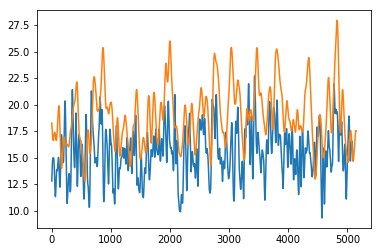

In [88]:
plt.plot(smooth(prediction[:, 0], window_len = 50)) #Blue one is prediction
plt.plot(smooth(trainy[:, 0],window_len = 100))

### Considering nature of outputs, I've used mean_absolute_error as loss metric, and net loss is 11.043

In [1]:
prediction.shape

NameError: name 'prediction' is not defined